<a href="https://colab.research.google.com/github/anaguilarar/crop-cv/blob/main/examples/seeds_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To speed up the process, please use the GPU by enabling the option in:
Runtime -> Change runtime type -> Hardware accelerator -> GPU.

In [3]:
import os
if not 'crop-cv' in os.listdir(os.getcwd()):
    !git clone https://github.com/anaguilarar/crop-cv.git
    print("Cloned")
    os.chdir("crop-cv")

else:
    print("cropdatacube directory already exists")
    os.chdir("crop-cv")


!pip install -r requirements.txt

from cropdatacube.datacubepredictors.segmentation import DLInstanceModel
from cropdatacube.datasets.data_preprocess import PreProcess_InstaData
from cropdatacube.phenotyping.counter import SeedsCounter
from cropdatacube.cropcv.readers import ImageReader
from cropdatacube.utils.general import FolderWithImages
from PIL import Image
from omegaconf import OmegaConf

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

cropdatacube directory already exists


### Configuration

Please check the configuration file called "seed_detection_configuration.yaml." This file contains all the requirements needed to implement this notebook. Among the requirements that may need modification is the "DATASET.image_path", which determines the location of the images to be analyzed, or OUTPUT.path to specify the results output folder.


In [4]:
# read configurtation file
configurationpath = "examples/seed_detection_configuration.yaml"
config = OmegaConf.load(configurationpath)


In [5]:
## download models weights
from cropdatacube.ml_utils.models.available import check_weigth_path

WEIGHTSPATH = check_weigth_path(config.MODEL.modelweigthurl, suffix=config.MODEL.model_output_name, weights_path="model_weights")



['maskrcnn_seeds_detection_20240607/checkpoint']


### Setting the model and datasets

Currently, the model analyzes images saved as ".jpg" or ".png". If both file types are in the same folder, it will only process the ones specified in 'images_suffix'.



In [6]:
PREDICTION_CONFIDENCE = 0.75
# model configuration
seg_model = DLInstanceModel(
        os.path.join("model_weights",config.MODEL.model_output_folder_name, config.MODEL.model_output_name))

# image preprocessing options
transformopts = PreProcess_InstaData(mean_scaler_values= config.DATASET.mean_scaler_values,
                                        std_scaler_values= config.DATASET.std_scaler_values)

# seed detection
seeds_analizer = SeedsCounter(
                        detector=seg_model.model,
                        device=seg_model.device,
                        detector_size = (config.MODEL.inputsize,config.MODEL.inputsize),
                        transform=transformopts)


inputpath = r'/content/crop-cv/data/seeds'
results_output = config.OUTPUT.path
## create output folder
if not os.path.exists(results_output):
    os.mkdir(results_output)

imagespath = FolderWithImages(path= inputpath, suffix='.jpg')

print(f"files available in folder: {len(imagespath.files_in_folder)}")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_V2_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth
100%|██████████| 177M/177M [00:01<00:00, 108MB/s]
/content/crop-cv/cropdatacube/datacubepredictors/segmentation.py:574: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pyto

Weights loaded
files available in folder: 3


### Detecting the rice seeds in an image

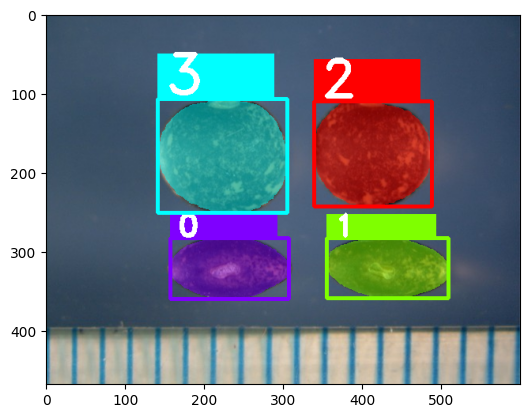

In [7]:
image_id = 2

imgr = ImageReader()
img = imgr.get_image(path = imagespath.files_in_folder[image_id])

seeds_analizer.detect_seeds(image=img,prediction_threshold=config.MODEL.prediction_threshold,
                           segmentation_threshold = config.MODEL.segmentation_threshold )

## show detections
imgseeds = seeds_analizer.visualize_detected_seeds(label_factorsize = config.PLOTS.label_factorsize,
                                                   heightframefactor = config.PLOTS.heightframefactor,
                                                   textthickness=4,
                                                   widthframefactor = config.PLOTS.widthframefactor)
plt.imshow(imgseeds)

#### Extracting information for a single seed
Several traits can be obtained for each detected seed. Some of them are shown in the example figure:
* Length: Represented by the green line, it is the longest distance on the seed's perimeter.
* Width: Represented by the purple line, it is the longest distance perpendicular to the length.
* Distance between centers: Represented by the gray line, it is the distance between the center of gravity (red dot) and the intersection point (black dot).

{'length': 99.82484660644363,
 'width': 50.91168824543142,
 'perimeter': 251.5218584537506,
 'distance_between_centers': 6.751875720819822,
 'area': 3945,
 'circularity': 0.01977897744564619,
 'roundness': 197.09751024586427,
 'length_to_width_ratio': 1.9607451657312003}

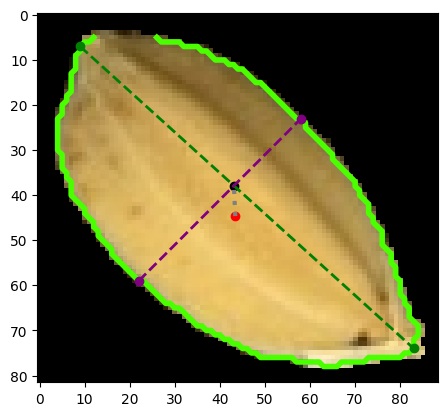

In [ ]:
seeds_analizer.single_seed_phenotyping(seedid=1,
                                       perpendicular_tolerance=0.1,
                                       padding_percentage=config.PROCESS.padding_percentage,
                                       color_spacelist= config.PROCESS.color_spacelist)

seeds_analizer.plot_individual_seed()
seeds_analizer.calculate_seed_morphometrics()

#### Color space
Besides the algorithm also allowed to calculate traits related to the seed color. By transforming the RGB image into new color spaces like CIELab.

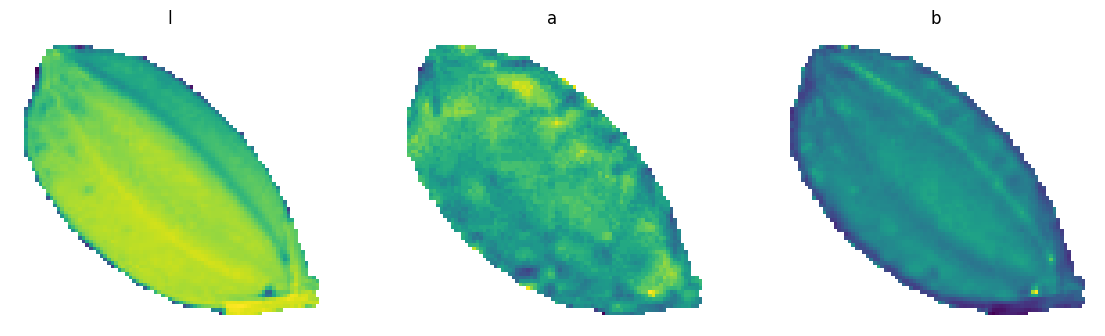

In [ ]:
f, ax = plt.subplots(ncols=3, figsize = (14,8))
cielabvalues = seeds_analizer._seed_colorspace['cielab']
for i, b in enumerate(['l','a','b']):
    ax[i].imshow(cielabvalues[:,:,i])
    ax[i].set_title(b)
    ax[i].set_axis_off()

#### Extracting information for all seeds

To visualize the results for each seed, the algorithm allows generating a plot that displays all the predictions and calculated metrics.

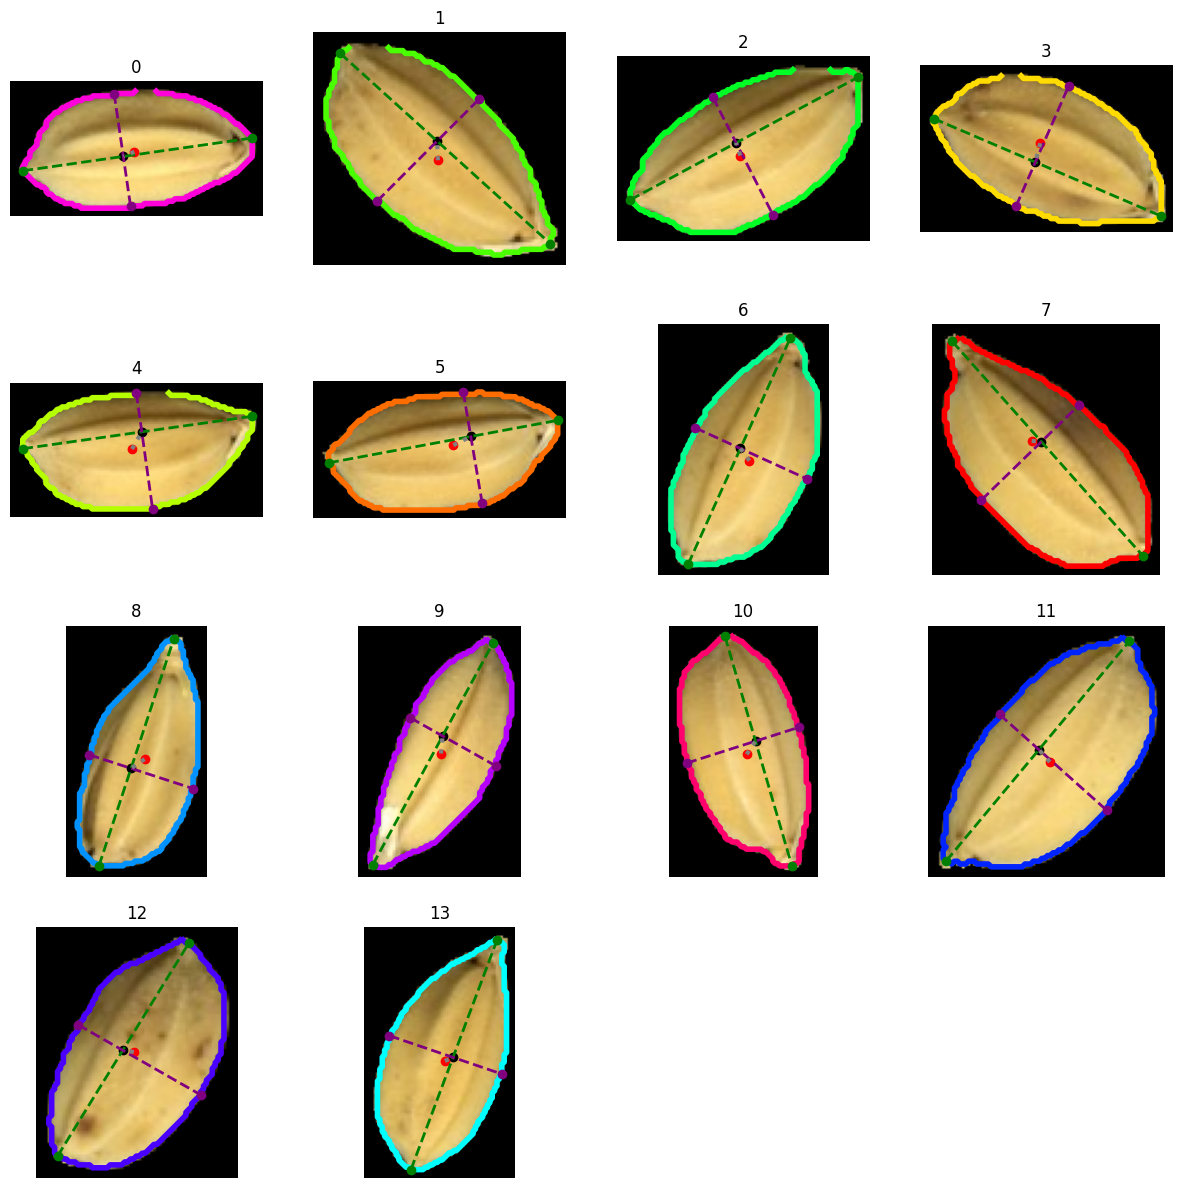

In [ ]:

f = seeds_analizer.plot_all_seeds_metrics(ncols = 4,perpendicular_tolerance=0.1, padding_percentage=config.PROCESS.padding_percentage, export_path = None, figsize = config.PLOTS.seeds_figsize)


In [ ]:
df = seeds_analizer.get_all_seed_metrics(perpendicular_tolerance=0.1,
                                       padding_percentage=config.PROCESS.padding_percentage,
                                       color_spacelist= config.PROCESS.color_spacelist, include_srgb = config.PROCESS.include_srgb,
                                       quantiles = config.PROCESS.color_quantiles)


df.to_csv('test.csv')
df

,length,width,perimeter,distance_between_centers,area,circularity,roundness,length_to_width_ratio,h_025,h_05,...,r_025,r_05,r_075,g_025,g_05,g_075,b_025,b_05,b_075,seedid
0,98.994949,48.507731,249.137083,5.117576,3907,0.020109,197.067452,2.040808,0.123464,0.127021,...,0.818290,0.921864,0.973684,0.759381,0.861693,0.919941,0.585568,0.673936,0.739218,seed_0
1,99.824847,50.911688,251.521858,6.751876,3945,0.019779,197.097510,1.960745,0.120338,0.122448,...,0.824993,0.916080,0.950090,0.756899,0.840360,0.874166,0.571487,0.631744,0.668119,seed_1
2,103.353761,52.773099,260.107645,5.351571,4272,0.019321,206.389686,1.958455,0.122514,0.124608,...,0.793075,0.916080,0.962890,0.731469,0.855366,0.900416,0.560628,0.662235,0.718312,seed_2
3,99.005050,52.392748,250.793936,7.811835,3994,0.020417,200.124792,1.889671,0.119224,0.122170,...,0.824993,0.874166,0.914141,0.749388,0.804665,0.840360,0.553237,0.602582,0.647221,seed_3
4,99.984999,50.487622,252.308656,8.523641,3948,0.019669,196.632300,1.980386,0.122236,0.124454,...,0.781260,0.929502,0.962890,0.718312,0.863788,0.896443,0.538065,0.653280,0.707556,seed_4
5,98.655968,47.675990,248.551297,8.262858,3875,0.020129,195.914030,2.069301,0.120731,0.123189,...,0.778868,0.919941,0.955603,0.710264,0.853244,0.888427,0.526319,0.660751,0.699347,seed_5
6,102.044108,50.566788,253.865004,6.220622,3995,0.018991,197.753332,2.018007,0.121988,0.124179,...,0.840360,0.904365,0.957432,0.774056,0.840360,0.890440,0.589021,0.644164,0.693804,seed_6
7,108.374351,51.623638,269.663995,3.684310,4369,0.017335,203.595861,2.099316,0.120437,0.123924,...,0.793075,0.896443,0.953770,0.723612,0.829421,0.884384,0.545718,0.628589,0.682543,seed_7
8,98.979796,45.221676,242.894442,6.799746,3400,0.017955,175.902173,2.188769,0.122915,0.125028,...,0.836007,0.916080,0.938934,0.778868,0.848978,0.876222,0.595851,0.650259,0.685381,seed_8
9,94.413982,36.715120,225.622364,6.603671,2709,0.016926,150.881754,2.571529,0.121778,0.124492,...,0.861693,0.931398,0.970104,0.802365,0.867959,0.906332,0.628589,0.679690,0.726244,seed_9


## Extracting the data for all the files that are inside the folder

If you drag your own images to the left panel, please modify the input path to '/content/' only

In [ ]:
import pandas as pd
from cropdatacube.phenotyping.calculate_seeds_metrics import batch_seed_image_detection


inputpath = r'/content/crop-cv/data/seeds'
imagespath = FolderWithImages(path= inputpath, suffix='.jpg')

results_output = 'detection'
alldata = batch_seed_image_detection( imagespath.files_in_folder, config, seeds_analizer, results_output, images_suffix = '.jpg')

pd.concat(alldata).to_csv(os.path.join(results_output,'alldata.csv'))

100%|██████████| 3/3 [00:10<00:00,  3.40s/it]


##### Compress output folder for downloading

In [ ]:
import zipfile
import glob

with zipfile.ZipFile(results_output + '.zip', 'w') as f:
    for file in glob.glob(results_output + '/*'):
        f.write(file)
